In [ ]:
# Create a DAG for demo_model_v2
# Only plot functions not variables

import networkx as nx
import matplotlib.pyplot as plt

# Create a new directed graph
G = nx.DiGraph()

# Define the nodes (functions)
functions = [
    "calculate_f1",
    "calculate_f2",
    "calculate_f3",
    "calculate_f4",
    "calculate_f5",
]

# Add nodes to the graph
G.add_nodes_from(functions)

# Define the edges (dependencies)
edges = [
    ("calculate_f2", "calculate_f3"),
    ("calculate_f2", "calculate_f4"),
    ("calculate_f3", "calculate_f5"),
    ("calculate_f4", "calculate_f5"),
]

# Add edges to represent dependencies
G.add_edges_from(edges)

# Plot and display the DAG
pos = nx.planar_layout(G)
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=5000, node_color='lightblue', font_size=10, font_color='black', arrows=True)
plt.title("Function Dependency DAG")
plt.show()


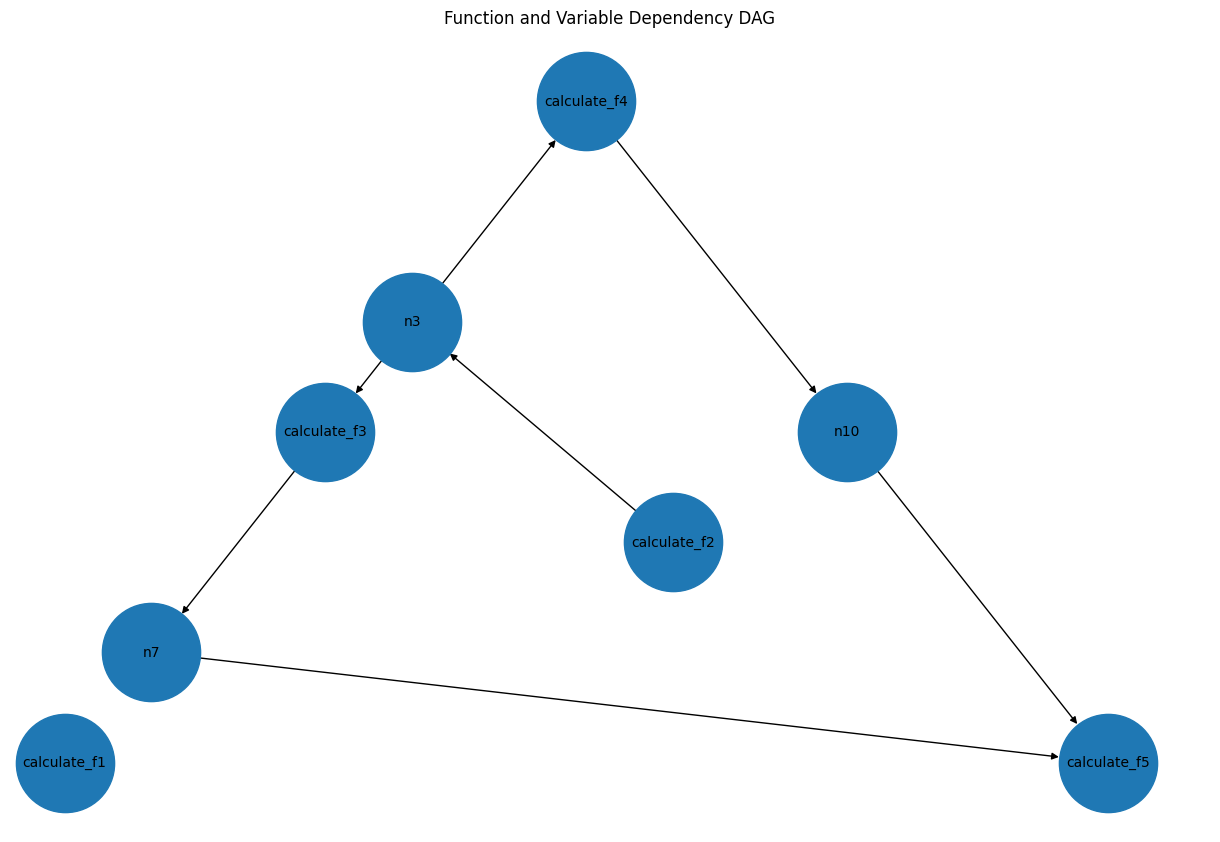

In [33]:
# DAG with 2 sets of nodes, function and variable nodes
# Can see the flow of variables through the model

import networkx as nx
import matplotlib.pyplot as plt

# Create a new directed graph
G = nx.DiGraph()

# Define the nodes (functions)
functions = [
    "calculate_f1",
    "calculate_f2",
    "calculate_f3",
    "calculate_f4",
    "calculate_f5",
]

# Define the nodes (variables)
variables = [
    "n3",
    "n7",
    "n10"
]

# Add function nodes to the graph and label them as 'function'
G.add_nodes_from(functions, node_type='function')

# Add variable nodes to the graph and label them as 'variable'
G.add_nodes_from(variables, node_type='variable')

# Define the edges (dependencies between functions)
function_edges = [
    ("calculate_f2", "n3"),  # Function produces variable
    ("calculate_f3", "n7"),  # Function produces variable
    ("calculate_f4", "n10"),  # Function produces variable
]

# Define the edges (dependencies between variables and functions)
variable_edges = [
    ("n3", "calculate_f3"),  # Variable passed to function
    ("n3", "calculate_f4"),  # Variable passed to function
    ("n7", "calculate_f5"),  # Variable passed to function
    ("n10", "calculate_f5")  # Variable passed to function
]

# Add edges to represent dependencies
G.add_edges_from(function_edges)
G.add_edges_from(variable_edges)

# Plot and display the DAG using the Planar Layout
plt.figure(figsize=(12, 8))
pos = nx.planar_layout(G, scale=1.5)
nx.draw(G, pos, with_labels=True, node_size=5000, font_size=10, font_color='black', arrows=True)
plt.title("Function and Variable Dependency DAG")
plt.show()


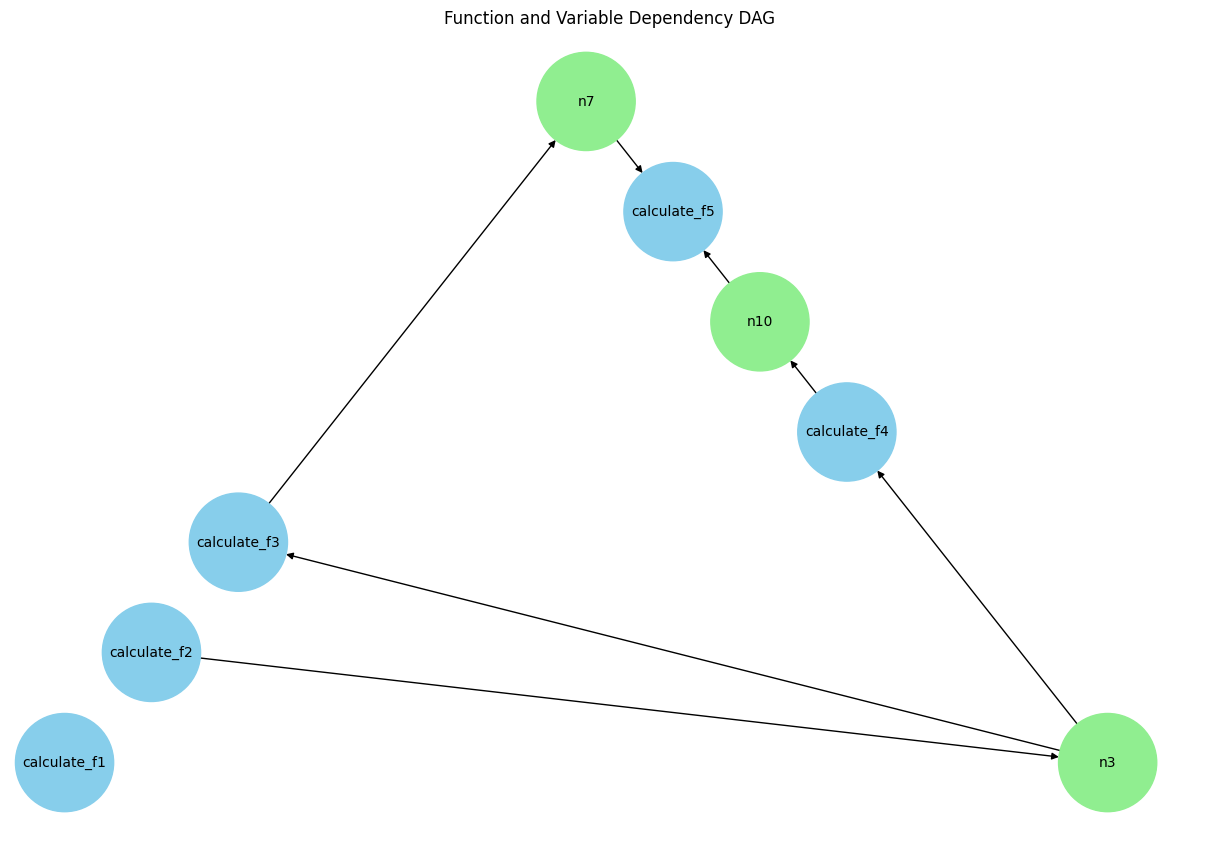

In [6]:
# DAG with 2 sets of nodes in different colours, function and variable nodes
# Can see the flow of variables through the model

import networkx as nx
import matplotlib.pyplot as plt

# Create a new graph
G = nx.DiGraph()

# Define the nodes (functions)
functions = [
    "calculate_f1",
    "calculate_f2",
    "calculate_f3",
    "calculate_f4",
    "calculate_f5",
]

# Define the nodes (variables) that are passed to functions
variables = [
    "n3",
    "n7",
    "n10"
]

# Add function nodes to the graph
G.add_nodes_from(functions)

# Add variable nodes to the graph
G.add_nodes_from(variables)

# Define the edges (dependencies between functions and variables)
function_edges = [
    ("calculate_f2", "n3"),  # Function produces variable
    ("calculate_f3", "n7"),  # Function produces variable
    ("calculate_f4", "n10"),  # Function produces variable
]

# Define the edges (dependencies between variables and functions)
variable_edges = [
    ("n3", "calculate_f3"),  # Variable passed to function
    ("n3", "calculate_f4"),  # Variable passed to function
    ("n7", "calculate_f5"),  # Variable passed to function
    ("n10", "calculate_f5")  # Variable passed to function
]

# Add edges to represent dependencies
G.add_edges_from(function_edges)
G.add_edges_from(variable_edges)

# Assign groups to nodes (0 for functions, 1 for variables)
groups = {node: 0 if node in functions else 1 for node in G.nodes()}

# Create a color map for nodes
color_map = ['skyblue' if groups[node] == 0 else 'lightgreen' for node in G.nodes()]

# Plot and display the DAG using the Planar Layout
plt.figure(figsize=(12, 8))
pos = nx.planar_layout(G, scale=1.5)
labels = {node: node for node in G.nodes()}
nx.draw(G, pos, with_labels=True, labels=labels, node_size=5000, font_size=10, font_color='black', node_color=color_map, arrows=True)
plt.title("Function and Variable Dependency DAG")
plt.show()

In [1]:
# Now that the DAG is made how can the required information be gathered by parsing the .py file containing this model?

# 1. Generate list of function names in the .py file
# 2. Get all the names of all variables that are dependencies (and the function that require them)


import ast
import os
import pandas as pd

def DAG_parse_file(file_path):
    DAG_data = pd.DataFrame()
    function_names = []
    
    ####################
    # Read the file
    ####################
    # Ensure the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return function_names
    
    # Parse the Python file
    with open(file_path, 'r') as file:
        tree = ast.parse(file.read())
    
    ####################
    # Get names of all functions
    ####################
    # Traverse the abstract syntax tree
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            function_names.append(node.name)
    
    # Remove demo_model, in package scripts this would be in a seperate file
    function_names.remove("demo_model")

    # Move data to a dataframe
    DAG_data['Function'] = function_names

    return DAG_data

DAG_data = DAG_parse_file('./demo_model_v2.py')




In [6]:
# This function gets all function names, variables needed as dependency and the variables a function returns
# Returns DAG_data, a dataframe with everything needed to plot DAG

import ast
import os
import pandas as pd
from icecream import ic

def DAG_parse_file(file_path):
    DAG_data = pd.DataFrame()
    function_names = []
    required_inputs = []
    function_returns = []

    ####################
    # Read the file
    ####################
    # Check file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return function_names
    
    # Parse the Python file
    with open(file_path, 'r') as file:
        tree = ast.parse(file.read())
    
    ####################
    # Get names of all functions and variables required as inputs
    ####################
    # Traverse the abstract syntax tree
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            function_name = node.name
            # Get argument names
            input_parameters = [arg.arg for arg in node.args.args]
            dependency_vars = []

            # Track whether we are collecting dependency variables
            collecting_dependency_vars = False

            # Iterate through the input parameters
            for arg_name in input_parameters:
                if collecting_dependency_vars:
                    dependency_vars.append(arg_name)
                if arg_name == 'in_model':
                    # Arguments are structured so that all required variables are named after the in_model argument
                    # Only start storing argument names that occur after in_model 
                    collecting_dependency_vars = True

            function_names.append(function_name)
            required_inputs.append(dependency_vars)

    ####################
    # Get dependency variables
    ####################
    # Traverse the abstract syntax tree
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            returned_vars = []

            # Iterate through the function's code
            for stmt in node.body:
                if isinstance(stmt, ast.Return):
                    # Get the returned variable names
                    returned_vars.extend([var.id for var in ast.walk(stmt) if isinstance(var, ast.Name)])
            function_returns.append(returned_vars)

    ####################
    # Move to a dataframe
    ####################
    DAG_data['function_name'] = function_names
    DAG_data['required_inputs'] = required_inputs
    DAG_data['function_returns'] = function_returns
    # Drop demo_data row
    DAG_data = DAG_data[DAG_data['function_name'] != 'demo_model']
    # Replace empty lists with NA
    DAG_data['required_inputs'] = DAG_data['required_inputs'].apply(lambda x: x if x else pd.NA)
  
    # Remove values in function_returns that are not in required_inputs
    unique_requirements = [value for value in DAG_data['required_inputs'].explode().unique() if value is not pd.NA]
    for index, row in DAG_data.iterrows():
        filtered_returns = [var if var in unique_requirements else pd.NA for var in row['function_returns']]
        DAG_data.at[index, 'function_returns'] = filtered_returns

    return DAG_data

# Example usage
DAG_data = DAG_parse_file('./demo_model_v2.py')
# print(DAG_data)

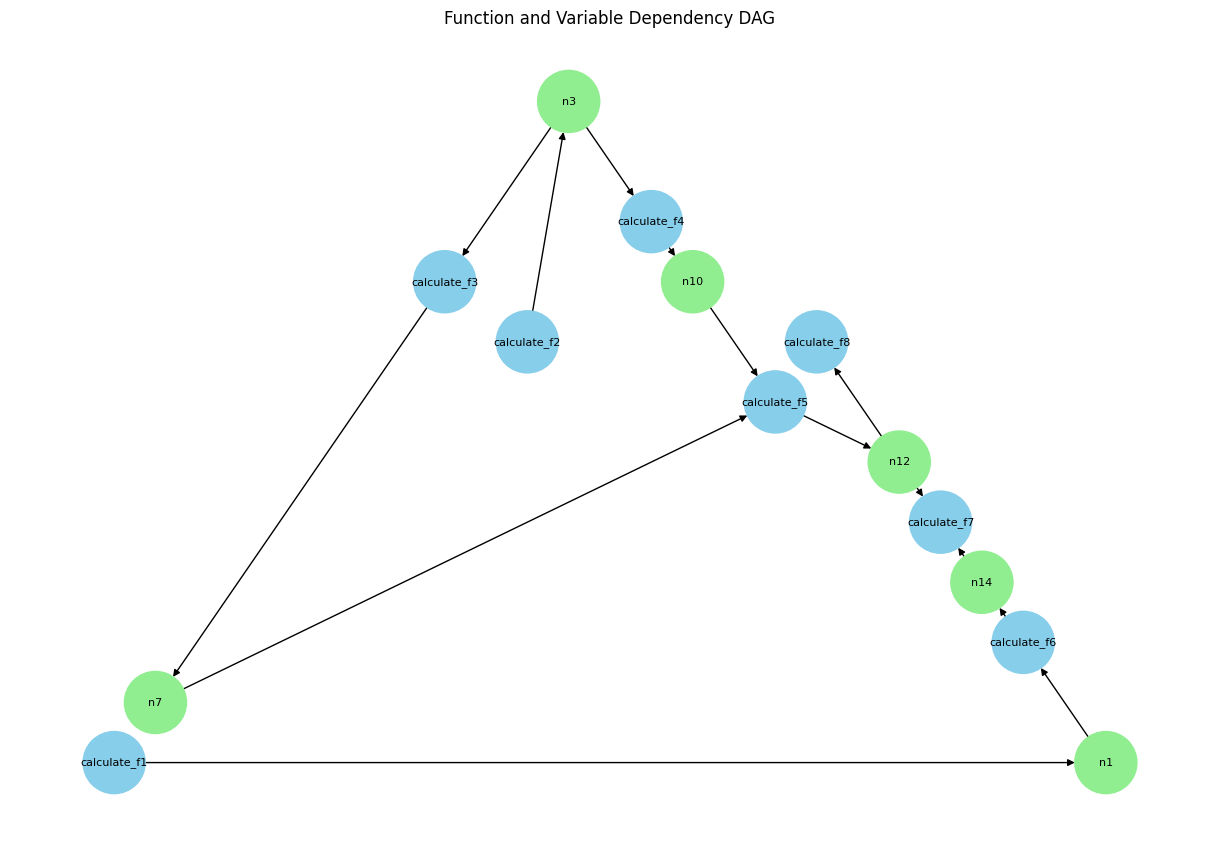

In [9]:
import ast
import os
import pandas as pd
from icecream import ic
# import scipy


# Parse Python file and collect data for DAG 
def DAG_parse_file(file_path):
    DAG_data = pd.DataFrame()
    function_names = []
    required_inputs = []
    function_returns = []

    ####################
    # Read the file
    ####################
    # Check file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return function_names
    
    # Parse the Python file
    with open(file_path, 'r') as file:
        tree = ast.parse(file.read())
    
    ####################
    # Get names of all functions and variables required as inputs
    ####################
    # Traverse the abstract syntax tree
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            function_name = node.name
            # Get argument names
            input_parameters = [arg.arg for arg in node.args.args]
            dependency_vars = []

            # Track whether we are collecting dependency variables
            collecting_dependency_vars = False

            # Iterate through the input parameters
            for arg_name in input_parameters:
                if collecting_dependency_vars:
                    dependency_vars.append(arg_name)
                if arg_name == 'in_model':
                    # Arguments are structured so that all required variables are named after the in_model argument
                    # Only start storing argument names that occur after in_model 
                    collecting_dependency_vars = True

            function_names.append(function_name)
            required_inputs.append(dependency_vars)

    ####################
    # Get dependency variables
    ####################
    # Traverse the abstract syntax tree
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            returned_vars = []

            # Iterate through the function's code
            for stmt in node.body:
                if isinstance(stmt, ast.Return):
                    # Get the returned variable names
                    returned_vars.extend([var.id for var in ast.walk(stmt) if isinstance(var, ast.Name)])
            function_returns.append(returned_vars)

    ####################
    # Move to a dataframe
    ####################
    DAG_data['function_name'] = function_names
    DAG_data['required_inputs'] = required_inputs
    DAG_data['function_returns'] = function_returns
    # Drop demo_data row
    DAG_data = DAG_data[DAG_data['function_name'] != 'demo_model']
    # Replace empty lists with NA
    DAG_data['required_inputs'] = DAG_data['required_inputs'].apply(lambda x: x if x else pd.NA)
  
    # Remove values in function_returns that are not in required_inputs
    unique_requirements = [value for value in DAG_data['required_inputs'].explode().unique() if value is not pd.NA]
    for index, row in DAG_data.iterrows():
        filtered_returns = [var if var in unique_requirements else pd.NA for var in row['function_returns']]
        DAG_data.at[index, 'function_returns'] = filtered_returns

    return DAG_data


# Create DAG using DAG_data
def create_DAG(data):
    import networkx as nx
    import matplotlib.pyplot as plt

    # Define function nodes
    functions = [value for value in data['function_name'].explode().unique() if value is not pd.NA]
    
    # Define variable nodes
    variables = [value for value in DAG_data['required_inputs'].explode().unique() if value is not pd.NA]
    
    # Define function edges
    function_edges = [(row['function_name'], variable) for index, row in DAG_data.iterrows() for variable in row['function_returns'] if variable is not pd.NA]
    
    # Define variable edge
    variable_edges = [(value, row['function_name']) for index, row in DAG_data.iterrows() if isinstance(row['required_inputs'], list) for value in row['required_inputs'] if value is not pd.NA]

    # Create a new graph
    G = nx.DiGraph()
    # Add nodes
    G.add_nodes_from(functions)
    G.add_nodes_from(variables)
    # Add edges to represent dependencies
    G.add_edges_from(function_edges)
    G.add_edges_from(variable_edges)
    # Assign colour to nodes
    groups = {node: 0 if node in functions else 1 for node in G.nodes()}
    color_map = ['skyblue' if groups[node] == 0 else 'lightgreen' for node in G.nodes()]

    # Plot and display the DAG
    plt.figure(figsize=(12, 8))
    # For positioning use one of the following equations: planar_layout, spring_layout
    pos = nx.planar_layout(G, scale=1.5)
    labels = {node: node for node in G.nodes()}
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=2000, font_size=8, font_color='black', node_color=color_map, arrows=True)
    plt.title("Function and Variable Dependency DAG")
    plt.show()


DAG_data = DAG_parse_file('./demo_model_v2.py')
# print(DAG_data)
create_DAG(DAG_data)
